In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

dir_path = r'train'
data_pattern = r'^.*_data\.csv$'
result_data = [f for f in os.listdir(dir_path) if re.match(data_pattern, f)]
events_pattern = r'^.*_events\.csv$'
result_events = [f for f in os.listdir(dir_path) if re.match(events_pattern, f)]

In [3]:
dir_path = r'train'
data_df_list = []
for file in result_data:
    df = pd.read_csv(os.path.join(dir_path, file))
    df.drop(['id'], axis=1, inplace=True) 
    data_df_list.append(df)

In [4]:
dir_path = r'train'
event_df_list = []
for file in result_events:
    df = pd.read_csv(os.path.join(dir_path, file))
    df.drop(['id'], axis=1, inplace=True) 
    event_df_list.append(df)

In [4]:
pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.


C:\Users\xuan\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


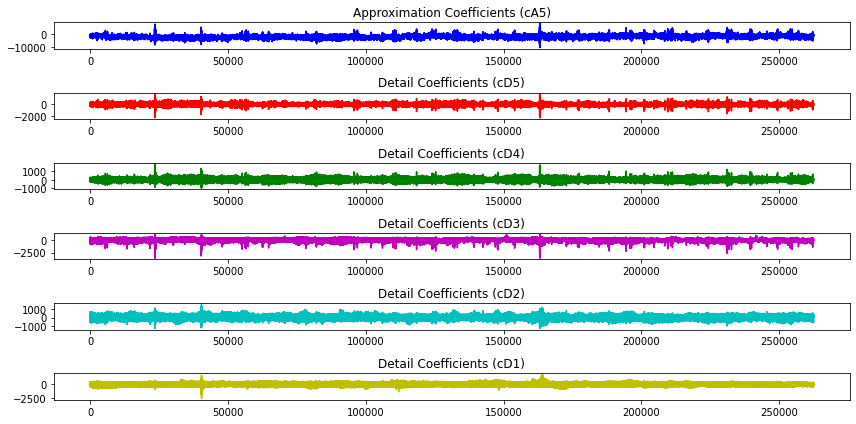

C:\Users\xuan\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


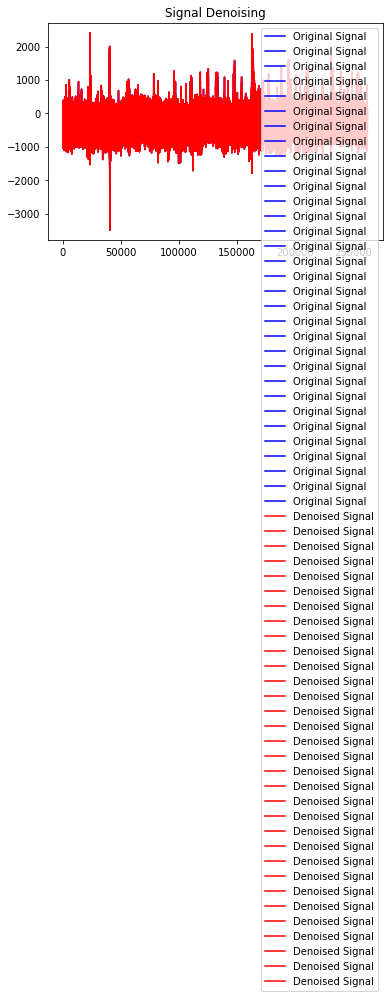

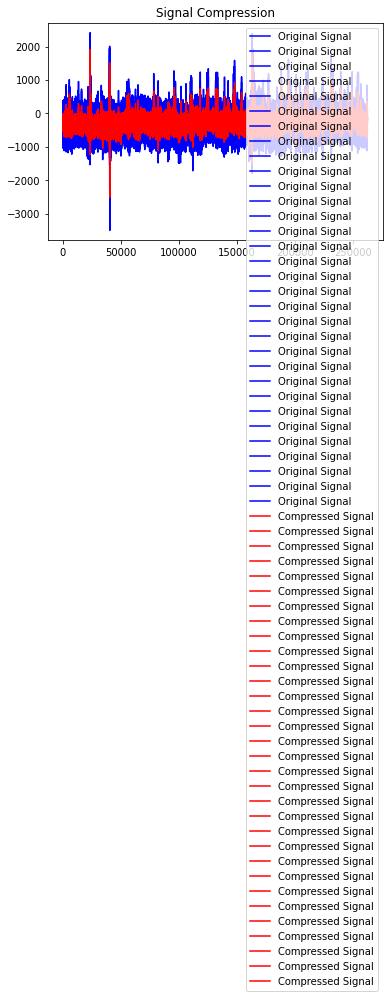

In [5]:
import pywt

x = [i for i in range(len(data_df_list[0]))]
y = data_df_list[0]

coeffs = pywt.wavedec(y, 'db4', level=5)

plt.figure(figsize=(12, 6))
plt.subplot(6, 1, 1)
plt.plot(x, coeffs[0], 'b')
plt.title('Approximation Coefficients (cA5)')
plt.subplot(6, 1, 2)
plt.plot(x, coeffs[1], 'r')
plt.title('Detail Coefficients (cD5)')
plt.subplot(6, 1, 3)
plt.plot(x, coeffs[2], 'g')
plt.title('Detail Coefficients (cD4)')
plt.subplot(6, 1, 4)
plt.plot(x, coeffs[3], 'm')
plt.title('Detail Coefficients (cD3)')
plt.subplot(6, 1, 5)
plt.plot(x, coeffs[4], 'c')
plt.title('Detail Coefficients (cD2)')
plt.subplot(6, 1, 6)
plt.plot(x, coeffs[5], 'y')
plt.title('Detail Coefficients (cD1)')
plt.tight_layout()
plt.show()

# 进行信号去噪
threshold = 0.5  # 设置阈值
denoised_coeffs = [pywt.threshold(c, threshold) for c in coeffs]

# 重构信号
denoised_signal = pywt.waverec(denoised_coeffs, 'db4')

# 绘制去噪后的信号
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'b', label='Original Signal')
plt.plot(x, denoised_signal, 'r', label='Denoised Signal')
plt.title('Signal Denoising')
plt.legend()
plt.show()

# 进行信号压缩
compression_ratio = 0.5  # 设置压缩比例
threshold = np.sqrt(2 * np.log(len(y))) * np.median(np.abs(coeffs[-1])) * compression_ratio

compressed_coeffs = [pywt.threshold(c, threshold) for c in coeffs]

# 重构信号
compressed_signal = pywt.waverec(compressed_coeffs, 'db4')

# 绘制压缩后的信号
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'b', label='Original Signal')
plt.plot(x, compressed_signal, 'r', label='Compressed Signal')
plt.title('Signal Compression')
plt.legend()
plt.show()

In [10]:
coeffs[0]

array([[-2336.51258701, -2311.95076352, -2340.97855081, ...,
        -2329.43553706, -2328.03997848, -1608.33967317],
       [-2335.74970504, -2305.38909712, -2341.29930703, ...,
        -2322.273394  , -2339.06657731, -1659.92663854],
       [-2504.38624858, -2477.45903987, -2510.94399865, ...,
        -2516.27875737, -2430.85454222, -1663.5850875 ],
       ...,
       [ -741.77330615,  -681.81807513,  -746.67448934, ...,
         -604.74917977, -1102.61515038, -1999.18441604],
       [ -653.80625759,  -592.67872848,  -657.78048235, ...,
         -513.05013939, -1024.04078478, -1784.51017563],
       [ -930.18870252,  -874.17235362,  -937.21474292, ...,
         -828.42376892, -1182.20248645, -1764.58334098]])

In [65]:

max_size = max([array.shape[1] for array in coeffs])
coeffs_3d = []
for coeff in coeffs:
    coeff_3d = np.expand_dims(coeff, axis=2)
    
    if coeff_3d.shape[1] < max_size:
        padding = max_size - coeff_3d.shape[1]
        padded_array = np.pad(coeff_3d, [(0, 0), (0, padding), (0, 0)], mode='constant')
        coeffs_3d.append(padded_array)
    else:
        coeffs_3d.append(coeff_3d)
    
    print(coeff_3d.shape)

result_array = np.concatenate(coeffs_3d, axis=2)

(262387, 7, 1)
(262387, 7, 1)
(262387, 8, 1)
(262387, 10, 1)
(262387, 13, 1)
(262387, 19, 1)


In [66]:
result_array.shape

(262387, 19, 6)

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 假設已經準備好 level 5 的 wavelet 係數作為輸入特徵，並對應的目標值
# x 是 wavelet 係數的數組，y 是對應的目標值
x = result_array
y = event_df_list[0].values

# 將數據轉換為 PyTorch 張量
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).long()

# 定義 CNN 模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 6)  # 二元分類，所以輸出維度為 2
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # 展平特徵圖
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 創建模型實例
model = CNN()

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
num_epochs = 10
batch_size = 10
total_samples = x.shape[0]

for epoch in range(num_epochs):
    # 打亂數據
    indices = torch.randperm(total_samples)
    x = x[indices]
    y = y[indices]
    
    for i in range(0, total_samples, batch_size):
        # 獲取一批數據
        inputs = x[i:i+batch_size]
        labels = y[i:i+batch_size]
        
        # 正向傳播
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        
        # 反向傳播和優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 輸出訓練過程中的損失
        if (i+1) % 10:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_samples}], Loss: {loss.item():.4f}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x432 and 1024x64)

### subject 1 serires 1

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = np.concatenate(coeffs, axis=1)
y = event_df_list[0]
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = .3, random_state = 1, stratify = y)

In [74]:
randomForestModel = RandomForestClassifier(n_estimators=100, criterion='gini')
randomForestModel.fit(X_train, y_train)
predicted = randomForestModel.predict(X_train)
#print(X)
#print(predicted)
#print(y_train)

print('訓練集: ',randomForestModel.score(X_train,y_train))
print('測試集: ',randomForestModel.score(X_test,y_test))

訓練集:  0.9999945554527141
測試集:  0.9369259499218721


### subject 1 series 2

In [75]:
# 生成一个示例信号
x = [i for i in range(len(data_df_list[1]))]
y = data_df_list[1]

# 执行小波变换
coeffs = pywt.wavedec(y, 'db4', level=5)

C:\Users\xuan\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [77]:
X = np.concatenate(coeffs, axis=1)
y = event_df_list[1]

predicted = randomForestModel.predict(X)
print('測試集2: ',randomForestModel.score(X,y))

測試集2:  0.9001858230392903


### subj 2 series 1

In [78]:
# 生成一个示例信号
x = [i for i in range(len(data_df_list[9]))]
y = data_df_list[9]

# 执行小波变换
coeffs = pywt.wavedec(y, 'db4', level=5)

X = np.concatenate(coeffs, axis=1)
y = event_df_list[9]

predicted = randomForestModel.predict(X)
print('測試集3: ',randomForestModel.score(X,y))

C:\Users\xuan\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


測試集3:  0.8222983540627095


In [81]:
pred = pd.DataFrame(predicted)
pred.to_csv("subj2_series1")

In [6]:
import pywt
t = data_df_list[0]
frequencies = [10, 50, 100]  # 設定信號的頻率成分
amplitudes = [1, 0.5, 0.2]  # 設定信號的振幅
signal = np.zeros_like(t)
for freq, amp in zip(frequencies, amplitudes):
    signal += amp * np.sin(2 * np.pi * freq * t)

# 進行小波變換
wavelet = 'morl'  # 選擇小波基函數
coeffs, _ = pywt.cwt(signal, np.arange(1, 128), wavelet)

# 繪製時頻圖
plt.imshow(np.abs(coeffs), extent=[0, 1, 1, 128], cmap='jet', aspect='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Time-Frequency Plot')
plt.show()

KeyboardInterrupt: 